In [10]:
import numpy as np
import pandas as pd
import os
from parameters import *
from data import *
from utils_local.nlp_ticker import *
from didipack.utils_didi.ridge import run_efficient_ridge
from didipack.trainer.trainer_ridge import TrainerRidge
from didipack.trainer.train_splitter import get_start_dates,get_chunks,get_tasks_for_current_node
import psutil
from train_main import set_ids_to_eight_k_df
from experiments_params import get_main_experiments
from scipy import stats
from matplotlib import pyplot as plt
import swifter
from tqdm import tqdm
import regex as re

In [3]:

from multiprocessing import Pool

In [4]:
args = didi.parse()
par = Params()
data = Data(par)

In [9]:
os.listdir(load_dir)

['2019.p', '2019.p_model.joblib', 'basic_parameters.p']

In [12]:
load_dir = r'\data\gpfs\projects\punim2039\EightK\res\temp\vec_pred\logistic_regression\OPT_125m\NEWS_SINGLE'

model_outputs = [os.path.join(load_dir, f) for f in os.listdir(load_dir) if re.match(r'\d+.p$', f)]
model_outputs

['\\data\\gpfs\\projects\\punim2039\\EightK\\res\\temp\\vec_pred\\logistic_regression\\OPT_125m\\NEWS_SINGLE\\2019.p']

In [67]:
crsp = data.load_crsp_daily()
crsp_sorted = crsp.sort_values(by=['permno', 'date'])
crsp_sorted.head(10)

,permno,date,ticker,prc,ret,bid,ask,shrout
0,10001,1993-01-04,GFGC,14.50,0.035714,14.00,14.50,1080.0
1,10001,1993-01-05,GFGC,-14.25,-0.017241,14.00,14.50,1080.0
2,10001,1993-01-06,GFGC,-14.25,0.000000,14.00,14.50,1080.0
3,10001,1993-01-07,GFGC,14.50,0.017544,14.00,14.50,1080.0
4,10001,1993-01-08,GFGC,14.50,0.000000,14.00,14.50,1080.0
5,10001,1993-01-11,GFGC,14.50,0.000000,14.00,14.50,1080.0
6,10001,1993-01-12,GFGC,-14.25,-0.017241,14.00,14.50,1080.0
7,10001,1993-01-13,GFGC,13.75,-0.035088,13.75,14.25,1080.0
8,10001,1993-01-14,GFGC,13.75,0.000000,13.75,14.25,1080.0
9,10001,1993-01-15,GFGC,-14.00,0.018182,13.75,14.25,1080.0


In [52]:
# read df from pickle
#date should be in datetime64[ns]
df = pd.read_pickle(model_outputs[0]).rename(columns={'ticker':'permno'})
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={'date': 'date_news'}, inplace=True)
df

,id,date_news,permno,y_true,y_pred,y_pred_prb,accuracy
0,RSN9503Sa_1903142g/ZXoFQcv6gmBgw/pawl3QNFjSIoQ...,2019-03-14,12060,1,0,0.482326,False
1,RSN9503Sa_1903142JFmJGq5vfxeek2MFXftvywd8OoRHE...,2019-03-14,12060,1,0,0.482326,False
2,RSN9503Sa_1903142JFmJGq5vfxeek2MFXftvywd8OoRHE...,2019-03-14,12060,1,0,0.482326,False
3,RSN9503Sa_1903142JFmJGq5vfxeek2MFXftvywd8OoRHE...,2019-03-14,12060,1,0,0.482326,False
4,RSN9473Sa_1903142pMHnKSw54utOPCaUYljHN6C0YVF25...,2019-03-14,47896,1,0,0.378632,False
...,...,...,...,...,...,...,...
550818,GNX9jy1NC_1904302FCJv4pD7gpDFOZcNzmZYc7UOumnuT...,2019-04-30,17108,0,1,0.539711,False
550819,GNXb27Sq3_1904302lMebdTY0Y6WfCEyWRiB/fKBMo1BxR...,2019-04-30,83683,1,1,0.541581,True
550820,GNXXg6Mm__1904302qZ67TDeRzKH4oiIrggGAOaiOYdNjx...,2019-04-30,83683,1,1,0.535069,True
550821,GNX9MzRV__19043024u0kdNIW88dqaShV1QNx8EYp0Ev4W...,2019-04-30,10200,0,0,0.467102,True


In [94]:
n_days_ahead = 1

print('Creating permno mapping')
crsp_grouped = crsp_sorted.groupby('permno')
permno_mapping = {}
permno_date_to_index_mapping = {}  # New mapping for date to index

for permno, group in tqdm(crsp_grouped):
    records = group[['date', 'prc', 'ret', 'bid', 'ask', 'shrout']].to_records(index=False)
    permno_mapping[permno] = records
    permno_date_to_index_mapping[permno] = {date: idx for idx, date in enumerate(group['date'])}


Creating permno mapping


100%|██████████| 14658/14658 [00:56<00:00, 261.16it/s]


In [106]:
# Function to perform binary search and get nth day return
def get_nth_day_return(row):
    permno = row['permno']
    date_news = row['date_news']

    trading_days = permno_mapping.get(permno, None)
    date_to_index = permno_date_to_index_mapping.get(permno, {})

    if trading_days is not None and date_news in date_to_index:
        start_index = date_to_index[date_news]
        nth_index = start_index + n_days_ahead

        if nth_index < len(trading_days):
            nth_day_data = trading_days[nth_index]
            return pd.Series({
                'date': nth_day_data.date,
                'prc': nth_day_data.prc,
                'ret': nth_day_data.ret,
                'bid': nth_day_data.bid,
                'ask': nth_day_data.ask,
                'shrout': nth_day_data.shrout
            })
    # Return default values if conditions are not met
    return pd.Series({
        'date': pd.NaT,
        'prc': None,
        'ret': None,
        'bid': None,
        'ask': None,
        'shrout': None
    })

tqdm.pandas(desc="Processing rows")
additional_columns = df.progress_apply(get_nth_day_return, axis=1)
for col in ['prc', 'ret', 'bid', 'ask', 'shrout']:
    additional_columns[col] = pd.to_numeric(additional_columns[col], errors='coerce')
df_merged = pd.concat([df, additional_columns], axis=1)
df_merged.rename(columns={'date': 'date_trade'}, inplace=True)
df_merged

Processing rows: 100%|██████████| 550823/550823 [01:19<00:00, 6970.65it/s] 


,id,date_news,permno,y_true,y_pred,y_pred_prb,accuracy,date_trade,prc,ret,bid,ask,shrout
0,RSN9503Sa_1903142g/ZXoFQcv6gmBgw/pawl3QNFjSIoQ...,2019-03-14,12060,1,0,0.482326,False,2019-03-15,9.96,-0.033010,9.97,9.98,8705080.0
1,RSN9503Sa_1903142JFmJGq5vfxeek2MFXftvywd8OoRHE...,2019-03-14,12060,1,0,0.482326,False,2019-03-15,9.96,-0.033010,9.97,9.98,8705080.0
2,RSN9503Sa_1903142JFmJGq5vfxeek2MFXftvywd8OoRHE...,2019-03-14,12060,1,0,0.482326,False,2019-03-15,9.96,-0.033010,9.97,9.98,8705080.0
3,RSN9503Sa_1903142JFmJGq5vfxeek2MFXftvywd8OoRHE...,2019-03-14,12060,1,0,0.482326,False,2019-03-15,9.96,-0.033010,9.97,9.98,8705080.0
4,RSN9473Sa_1903142pMHnKSw54utOPCaUYljHN6C0YVF25...,2019-03-14,47896,1,0,0.378632,False,2019-03-15,106.55,0.011487,106.52,106.53,3274242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
550818,GNX9jy1NC_1904302FCJv4pD7gpDFOZcNzmZYc7UOumnuT...,2019-04-30,17108,0,1,0.539711,False,2019-05-01,30.21,-0.047003,30.21,30.29,25999.0
550819,GNXb27Sq3_1904302lMebdTY0Y6WfCEyWRiB/fKBMo1BxR...,2019-04-30,83683,1,1,0.541581,True,2019-05-01,19.84,-0.020247,19.76,20.23,7497.0
550820,GNXXg6Mm__1904302qZ67TDeRzKH4oiIrggGAOaiOYdNjx...,2019-04-30,83683,1,1,0.535069,True,2019-05-01,19.84,-0.020247,19.76,20.23,7497.0
550821,GNX9MzRV__19043024u0kdNIW88dqaShV1QNx8EYp0Ev4W...,2019-04-30,10200,0,0,0.467102,True,2019-05-01,65.82,-0.023152,65.77,65.80,44074.0


In [116]:
print(additional_columns.head(10))

print(additional_columns.dtypes)

        date     prc       ret     bid     ask     shrout
0 2019-03-15    9.96 -0.033010    9.97    9.98  8705080.0
1 2019-03-15    9.96 -0.033010    9.97    9.98  8705080.0
2 2019-03-15    9.96 -0.033010    9.97    9.98  8705080.0
3 2019-03-15    9.96 -0.033010    9.97    9.98  8705080.0
4 2019-03-15  106.55  0.011487  106.52  106.53  3274242.0
5 2019-03-15  106.55  0.011487  106.52  106.53  3274242.0
6 2019-03-15  106.55  0.011487  106.52  106.53  3274242.0
7 2019-03-15   24.80  0.015145   24.80   24.81   196413.0
8 2019-03-15   24.80  0.015145   24.80   24.81   196413.0
9 2019-03-15   24.80  0.015145   24.80   24.81   196413.0
date      datetime64[ns]
prc              float64
ret              float64
bid              float64
ask              float64
shrout           float64
dtype: object


In [14]:
df.groupby('y_true')['y_pred_prb'].mean()

y_true
0    0.515216
1    0.521503
Name: y_pred_prb, dtype: float32

In [15]:
# Count of y_true = 1 and 0
df.groupby('y_true')['y_true'].count()


y_true
0    252744
1    298079
Name: y_true, dtype: int64

In [16]:
print(df['y_true'].mean(), df['y_pred_prb'].mean())

0.5411520579206024 0.51861787


In [17]:

accuracy = df['accuracy'].sum() / df.shape[0]
accuracy

0.5369783033751314

In [111]:
df_merged.dtypes

id                    object
date_news     datetime64[ns]
permno                 int64
y_true                 int32
y_pred                 int32
y_pred_prb           float32
accuracy                bool
date_trade    datetime64[ns]
prc                   object
ret                   object
bid                   object
ask                   object
shrout                object
dtype: object

In [119]:
df_grouped =df_merged.groupby(['permno','date_news'])[['ret','y_pred_prb','y_true', 'prc']].mean().reset_index()

df_grouped['year'] = df_grouped['date_news'].dt.year
print(df_grouped.groupby('year')['y_pred_prb'].mean())
df_grouped['tresh'] = df_grouped.groupby('year')['y_pred_prb'].transform('mean')

year
2019    0.520388
Name: y_pred_prb, dtype: float32


In [121]:
df_grouped['pred'] = df_grouped['y_pred_prb']>df_grouped['tresh']
# df['pred'] = df['y_pred_prb']>0
df_grouped['accuracy']=df_grouped['pred']==df_grouped['y_true']
df_grouped['accuracy'].mean()

0.5427917359837336

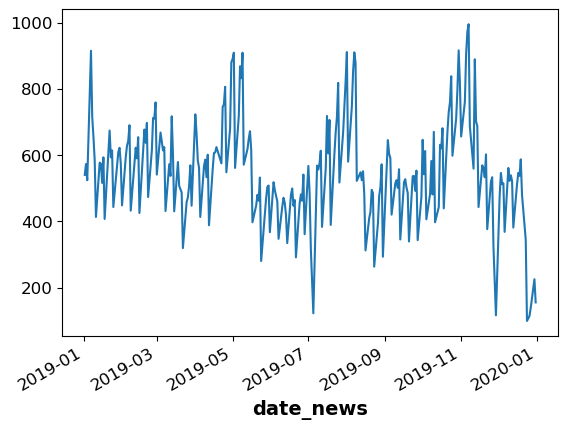

In [169]:

df_grouped.groupby('date_news')['permno'].count().plot()
df_grouped['pct']=df_grouped.groupby('date_news')['y_pred_prb'].rank(pct=True)

In [125]:
df_grouped

,permno,date_news,ret,y_pred_prb,y_true,prc,year,tresh,pred,accuracy,pct
0,10026,2019-01-16,0.013348,0.526021,0.0,145.75999,2019,0.520388,True,False,0.532946
1,10026,2019-01-28,0.120143,0.513417,0.0,156.82001,2019,0.520388,False,True,0.330389
2,10026,2019-01-29,-0.040301,0.556095,1.0,150.50000,2019,0.520388,True,True,0.848933
3,10026,2019-01-31,0.002915,0.542510,1.0,154.80000,2019,0.520388,True,True,0.773519
4,10026,2019-02-06,-0.011565,0.543348,0.0,156.41000,2019,0.520388,True,False,0.765163
...,...,...,...,...,...,...,...,...,...,...,...
140653,93436,2019-12-24,0.013380,0.550853,1.0,430.94000,2019,0.520388,True,True,0.868687
140654,93436,2019-12-26,-0.001299,0.556635,1.0,430.38000,2019,0.520388,True,True,0.894737
140655,93436,2019-12-27,-0.036433,0.540639,0.0,414.70001,2019,0.520388,True,False,0.768116
140656,93436,2019-12-30,0.008753,0.532249,0.0,418.32999,2019,0.520388,True,False,0.648889


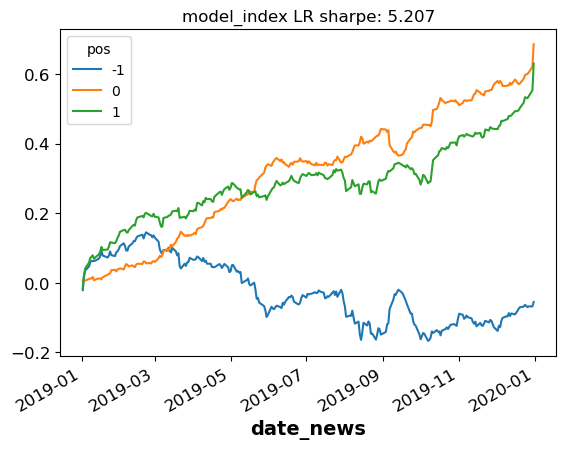

In [127]:
tresh = 0.2
df_grouped['pos'] = 1*(df_grouped['pct']>(1-tresh)) - (df_grouped['pct']<=tresh)*1
ret=df_grouped.groupby(['date_news','pos'])['ret'].mean().reset_index().pivot(columns='pos',index='date_news',values='ret')
ret[0] = ret[1]-ret[-1]
ret.cumsum().plot()
sh = np.sqrt(252)*(ret.mean()/ret.std()).round(3)
plt.title(f'model_index {"LR"} sharpe: {np.round(sh[0],3)}')
plt.show()

In [128]:
sh

pos
-1   -0.301616
 0    5.206839
 1    3.682886
dtype: float64

In [167]:
# index ret by [1, -1, 0]
ret_formated = ret[[1, -1, 0]]
sh_formated = np.sqrt(252)*(ret_formated.mean()/ret_formated.std()).round(3)
print("        ", "Long", "Short", "L-S", sep="\t")
print("Return: ", *list((252 * ret_formated.mean()).round(3)), sep="\t")
print("Std:    ", *list((np.sqrt(252)*ret_formated.std()).round(3)), sep="\t")
print("Sharpe: ", *list(sh_formated.round(3)), sep="\t")

        	Long	Short	L-S
Return: 	0.63	-0.056	0.685
Std:    	0.171	0.187	0.131
Sharpe: 	3.683	-0.302	5.207


In [168]:
df_grouped

,permno,date_news,ret,y_pred_prb,y_true,prc,year,tresh,pred,accuracy,pct,pos
0,10026,2019-01-16,0.013348,0.526021,0.0,145.75999,2019,0.520388,True,False,0.532946,0
1,10026,2019-01-28,0.120143,0.513417,0.0,156.82001,2019,0.520388,False,True,0.330389,0
2,10026,2019-01-29,-0.040301,0.556095,1.0,150.50000,2019,0.520388,True,True,0.848933,1
3,10026,2019-01-31,0.002915,0.542510,1.0,154.80000,2019,0.520388,True,True,0.773519,0
4,10026,2019-02-06,-0.011565,0.543348,0.0,156.41000,2019,0.520388,True,False,0.765163,0
...,...,...,...,...,...,...,...,...,...,...,...,...
140653,93436,2019-12-24,0.013380,0.550853,1.0,430.94000,2019,0.520388,True,True,0.868687,1
140654,93436,2019-12-26,-0.001299,0.556635,1.0,430.38000,2019,0.520388,True,True,0.894737,1
140655,93436,2019-12-27,-0.036433,0.540639,0.0,414.70001,2019,0.520388,True,False,0.768116,0
140656,93436,2019-12-30,0.008753,0.532249,0.0,418.32999,2019,0.520388,True,False,0.648889,0


array([[<Axes: title={'center': 'y_pred_prb'}>]], dtype=object)

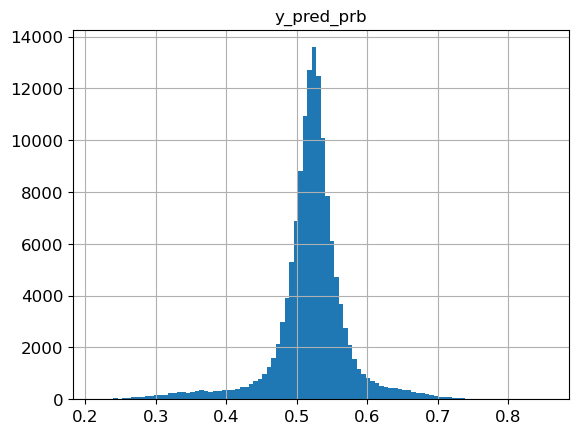

In [172]:
df_grouped.hist('y_pred_prb',bins=100)

In [175]:
df_grouped

,permno,date_news,ret,y_pred_prb,y_true,prc,year,tresh,pred,accuracy,pct,pos
0,10026,2019-01-16,0.013348,0.526021,0.0,145.75999,2019,0.520388,True,False,0.532946,0
1,10026,2019-01-28,0.120143,0.513417,0.0,156.82001,2019,0.520388,False,True,0.330389,0
2,10026,2019-01-29,-0.040301,0.556095,1.0,150.50000,2019,0.520388,True,True,0.848933,1
3,10026,2019-01-31,0.002915,0.542510,1.0,154.80000,2019,0.520388,True,True,0.773519,0
4,10026,2019-02-06,-0.011565,0.543348,0.0,156.41000,2019,0.520388,True,False,0.765163,0
...,...,...,...,...,...,...,...,...,...,...,...,...
140653,93436,2019-12-24,0.013380,0.550853,1.0,430.94000,2019,0.520388,True,True,0.868687,1
140654,93436,2019-12-26,-0.001299,0.556635,1.0,430.38000,2019,0.520388,True,True,0.894737,1
140655,93436,2019-12-27,-0.036433,0.540639,0.0,414.70001,2019,0.520388,True,False,0.768116,0
140656,93436,2019-12-30,0.008753,0.532249,0.0,418.32999,2019,0.520388,True,False,0.648889,0


In [179]:
apple_2019 = df_grouped[df_grouped['permno']==14593]
apple_2019['month'] = apple_2019['date_news'].dt.month
apple_2019_monthly = apple_2019.groupby('month')['y_pred_prb'].transform('mean')
apple_2019_monthly

C:\Users\nxcle\AppData\Local\Temp\ipykernel_38168\2962969834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_2019['month'] = apple_2019['date_news'].dt.month


23571    0.484206
23572    0.484206
23573    0.484206
23574    0.484206
23575    0.484206
           ...   
23802    0.535646
23803    0.535646
23804    0.535646
23805    0.535646
23806    0.535646
Name: y_pred_prb, Length: 236, dtype: float32

<Axes: xlabel='month'>

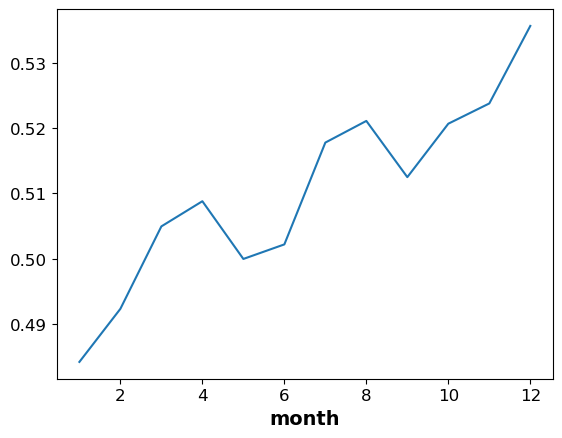

In [181]:
apple_2019.groupby('month')['y_pred_prb'].mean().plot()

<Axes: xlabel='date_news'>

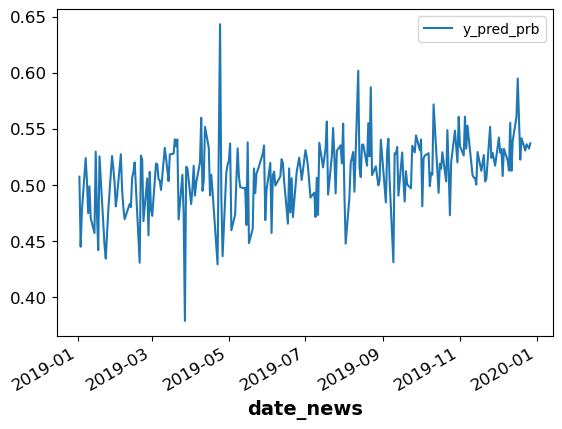

In [177]:
apple_2019.plot('date_news','y_pred_prb')